# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 3000-4000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 

Same as CNN 118 but switch cell line 1 to 3.

In [164]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 16:12:12.358660
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [165]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=3000
MAXLEN=4000   

In [166]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [167]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [168]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=3
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 3 = HepG2


## Data Load

In [169]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [170]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 16:12:15.072169
Load RCI values...
Num RCI: 9424
Example RCI: [('ENSG00000000003', 2.29436), ('ENSG00000000419', 1.43865), ('ENSG00000000457', -0.47502)]
Load genes...
2022-12-29 16:12:15.106773
Load sequence...
2022-12-29 16:12:24.108647
Num IDs: 5302
Example IDs: [('ENSG00000116198', 'ENST00000428079.6'), ('ENSG00000171680', 'ENST00000340850.10'), ('ENSG00000142599', 'ENST00000656437.1'), ('ENSG00000048707', 'ENST00000543766.2')]
Count 2101 ones out of 5302 labels.
Example labels: [0, 0, 0, 0]
Num counts: 5302
Example sequence: [126, 245, 212, 79, 57, 228, 144, 61, 241, 194, 8, 30, 118, 214, 86, 85, 81, 67, 11, 44, 174, 182, 216, 95, 122, 229, 148, 77, 52, 208, 64, 256, 254, 248, 222, 117, 209, 68, 15, 59, 235, 170, 166, 149, 82, 70, 23, 90, 103, 154, 102, 150, 87, 91, 106, 166, 149, 83, 73, 33, 131, 9, 36, 144, 64, 256, 256, 253, 244, 207, 59, 236, 173, 177, 193, 1, 4, 16, 64, 256, 255, 252, 239, 185, 228, 143, 59, 235, 169, 161, 129, 1, 2, 8, 30, 117, 212, 78, 54, 214, 8

## Model

In [171]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    #pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [172]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 16:12:24.149056
COMPILE
Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_85 (Embedding)    (None, 3997, 4)           1028      
                                                                 
 conv1d_85 (Conv1D)          (None, 3990, 64)          2112      
                                                                 
 global_average_pooling1d_72  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_169 (Dense)           (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [173]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 16:12:24.358441
2022-12-29 16:12:24.358645
splitting
Fold 1
Training example
[ 62 246 215 ...   0   0   0]
Train sizes (4250, 3997) (4250, 1)
Valid sizes (1052, 3997) (1052, 1)
Train set ones/size 1713 / 4250
Valid set ones/size 388 / 1052
BUILD MODEL
COMPILE
FIT
2022-12-29 16:12:25.681940
Epoch 1/5
133/133 [==============================] - 2s 9ms/step - loss: 0.6472 - accuracy: 0.6127 - val_loss: 0.5759 - val_accuracy: 0.6635
Epoch 2/5
133/133 [==============================] - 1s 7ms/step - loss: 0.6003 - accuracy: 0.6565 - val_loss: 0.5702 - val_accuracy: 0.6654
Epoch 3/5
133/133 [==============================] - 1s 7ms/step - loss: 0.5953 - accuracy: 0.6671 - val_loss: 0.5651 - val_accuracy: 0.6721
Epoch 4/5
133/133 [==============================] - 1s 7ms/step - loss: 0.5928 - accuracy: 0.6696 - val_loss: 0.5634 - val_accuracy: 0.6711
Epoch 5/5
133/133 [==============================] - 1s 7ms/step - loss: 0.5895 - accuracy: 0.6746 - val_loss: 0.5615 - val_accuracy: 

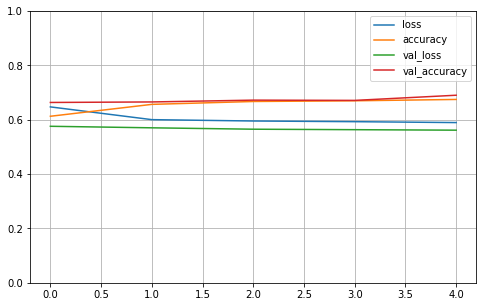

Compute valiation accuracy
2022-12-29 16:12:31.651802
Range of scores: 0.05357696 to 0.8518764
Predicted zeros and ones 698 354
Accuracy: 69.01% Precision: 58.76% Recall: 53.61% F1: 56.06%
2022-12-29 16:12:31.898381
Fold 2
Training example
[ 62 246 215 ...   0   0   0]
Train sizes (4201, 3997) (4201, 1)
Valid sizes (1101, 3997) (1101, 1)
Train set ones/size 1705 / 4201
Valid set ones/size 396 / 1101
BUILD MODEL
COMPILE
FIT
2022-12-29 16:12:33.171485
Epoch 1/5
132/132 [==============================] - 2s 9ms/step - loss: 0.6433 - accuracy: 0.6129 - val_loss: 0.5831 - val_accuracy: 0.6812
Epoch 2/5
132/132 [==============================] - 1s 7ms/step - loss: 0.5984 - accuracy: 0.6570 - val_loss: 0.5786 - val_accuracy: 0.6730
Epoch 3/5
132/132 [==============================] - 1s 7ms/step - loss: 0.5934 - accuracy: 0.6639 - val_loss: 0.5766 - val_accuracy: 0.6830
Epoch 4/5
132/132 [==============================] - 1s 7ms/step - loss: 0.5879 - accuracy: 0.6732 - val_loss: 0.5752 - val

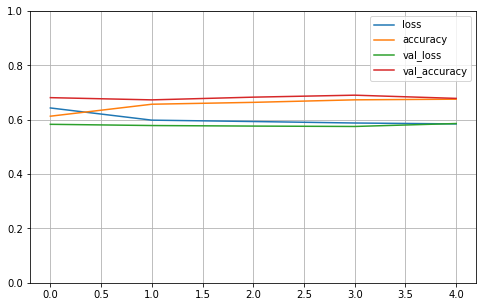

Compute valiation accuracy
2022-12-29 16:12:39.004516
Range of scores: 0.045943737 to 0.84300846
Predicted zeros and ones 663 438
Accuracy: 67.85% Precision: 54.79% Recall: 60.61% F1: 57.55%
2022-12-29 16:12:39.195657
Fold 3
Training example
[ 62 246 215 ...   0   0   0]
Train sizes (4294, 3997) (4294, 1)
Valid sizes (1008, 3997) (1008, 1)
Train set ones/size 1642 / 4294
Valid set ones/size 459 / 1008
BUILD MODEL
COMPILE
FIT
2022-12-29 16:12:40.480759
Epoch 1/5
135/135 [==============================] - 2s 9ms/step - loss: 0.6376 - accuracy: 0.6230 - val_loss: 0.6214 - val_accuracy: 0.6627
Epoch 2/5
135/135 [==============================] - 1s 7ms/step - loss: 0.5876 - accuracy: 0.6646 - val_loss: 0.6250 - val_accuracy: 0.6617
Epoch 3/5
135/135 [==============================] - 1s 8ms/step - loss: 0.5829 - accuracy: 0.6651 - val_loss: 0.6249 - val_accuracy: 0.6548
Epoch 4/5
135/135 [==============================] - 1s 7ms/step - loss: 0.5806 - accuracy: 0.6726 - val_loss: 0.6188 - v

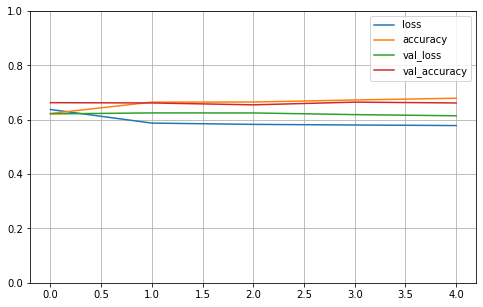

Compute valiation accuracy
2022-12-29 16:12:51.493606
Range of scores: 0.04346751 to 0.8314237
Predicted zeros and ones 646 362
Accuracy: 66.17% Precision: 66.30% Recall: 52.29% F1: 58.47%
2022-12-29 16:12:51.695717
Fold 4
Training example
[158 117 210 ...   0   0   0]
Train sizes (4279, 3997) (4279, 1)
Valid sizes (1023, 3997) (1023, 1)
Train set ones/size 1700 / 4279
Valid set ones/size 401 / 1023
BUILD MODEL
COMPILE
FIT
2022-12-29 16:12:53.004438
Epoch 1/5
134/134 [==============================] - 2s 9ms/step - loss: 0.6415 - accuracy: 0.6144 - val_loss: 0.6053 - val_accuracy: 0.6637
Epoch 2/5
134/134 [==============================] - 1s 7ms/step - loss: 0.5919 - accuracy: 0.6602 - val_loss: 0.6015 - val_accuracy: 0.6764
Epoch 3/5
134/134 [==============================] - 1s 7ms/step - loss: 0.5889 - accuracy: 0.6635 - val_loss: 0.5997 - val_accuracy: 0.6745
Epoch 4/5
134/134 [==============================] - 1s 7ms/step - loss: 0.5844 - accuracy: 0.6710 - val_loss: 0.5938 - val

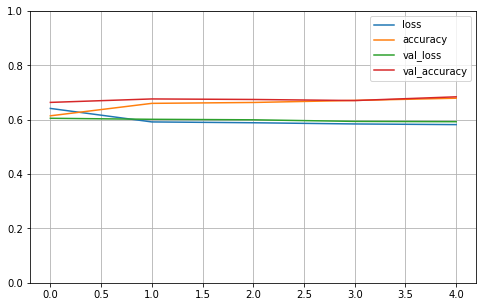

Compute valiation accuracy
2022-12-29 16:12:58.863711
Range of scores: 0.06204818 to 0.84103733
Predicted zeros and ones 627 396
Accuracy: 68.43% Precision: 59.85% Recall: 59.10% F1: 59.47%
2022-12-29 16:12:59.110149
Fold 5
Training example
[ 62 246 215 ...   0   0   0]
Train sizes (4184, 3997) (4184, 1)
Valid sizes (1118, 3997) (1118, 1)
Train set ones/size 1644 / 4184
Valid set ones/size 457 / 1118
BUILD MODEL
COMPILE
FIT
2022-12-29 16:13:00.380185
Epoch 1/5
131/131 [==============================] - 2s 9ms/step - loss: 0.6421 - accuracy: 0.6147 - val_loss: 0.5981 - val_accuracy: 0.6377
Epoch 2/5
131/131 [==============================] - 1s 7ms/step - loss: 0.5923 - accuracy: 0.6733 - val_loss: 0.5944 - val_accuracy: 0.6351
Epoch 3/5
131/131 [==============================] - 1s 7ms/step - loss: 0.5882 - accuracy: 0.6757 - val_loss: 0.5935 - val_accuracy: 0.6395
Epoch 4/5
131/131 [==============================] - 1s 8ms/step - loss: 0.5818 - accuracy: 0.6848 - val_loss: 0.5944 - va

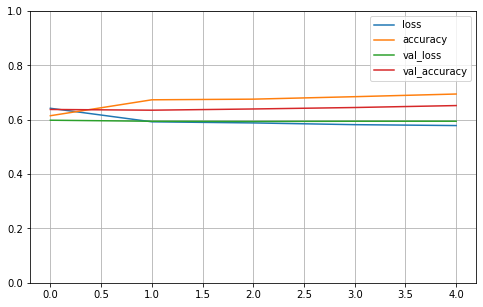

Compute valiation accuracy
2022-12-29 16:13:06.289136
Range of scores: 0.04461043 to 0.87569755
Predicted zeros and ones 678 440
Accuracy: 65.21% Precision: 57.73% Recall: 55.58% F1: 56.63%
2022-12-29 16:13:06.537644

Cross validation 5 folds 5 epochs
 accuracy mean 67.33% +/- 1.43
 precision mean 59.49% +/- 3.80
 recall mean 56.24% +/- 3.17
 F1 mean 57.64% +/- 1.23
2022-12-29 16:13:06.539709


In [174]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())